In [1]:
import shutil
import sys
import os
from glob import glob
from importlib import reload

sys.path.insert(0, "/home/2649/repos/TRANSSClass/scripts")
import TRANSSC_utils as utils

"""Import community packages"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

"""Import packages written for SNIDsn, astrodash, and Willow Fortino's (me) dgspec."""
import SNIDsn
import SNIDdataset as snid
import SNePCA

import degrade
import kernels
import plotutils
import utils
import classify_PCASVC as cps

import create_training_set as cts
import training_parameters as tp
import deep_learning_multilayer as dlm
import model_metrics as mm

R_vals = [
    738, 700, 600, 500, 400, 300,
    200, 175, 150, 125, 100,
    90, 80, 70, 60, 50,
    45, 40, 35, 30, 25, 20, 15, 10, 5
]

Instructions for updating:
non-resource variables are not supported in the long term


# Results

In [2]:
def plot_DASH_history(
    history,
    title="",
    no_broad=True):
    plt.figure(figsize=(12, 6))
    plt.plot(
        history["batch_iteration"], history["batch_trn_acc"],
        label="Batch Training: Type & Age")

    plt.plot(
        history["batch_iteration"], history["type_age_acc"],
        label="Type & Age")

    plt.plot(
        history["batch_iteration"], history["type_acc"],
        label="Type")

    plt.plot(
        history["batch_iteration"], history["type_nearage_acc"],
        label="Type & Near-Age")

    if not no_broad:
        plt.plot(
            history["batch_iteration"], history["broadtype_age_acc"],
            marker="x", ls="", label="Broad Type & Age")
        plt.plot(
            history["batch_iteration"], history["broadtype_acc"],
            marker="x", ls="", label="Broad Type")
        plt.plot(
            history["batch_iteration"], history["broadtype_nearage_acc"],
            marker="x", ls="", label="Broad Type & Near-Age")

    plt.legend(loc="upper left")

    plt.xlim((history["batch_iteration"].iloc[0],
              history["batch_iteration"].iloc[-1]))
    plt.ylim((0, 1.01))
    
    plt.xlabel("Batch Iteration Step")
    plt.ylabel("Categorical Cross Accuracy")
    plt.title(title)
    
    plt.grid()
    plt.show()

In [3]:
def plot_R_vs_acc(
    R_vals,
    acc_vals, acc_uncer_vals,
    broadacc_vals, broadacc_uncer_vals,
    title=""
):

    plt.figure(figsize=(14, 7))
    plt.title(title)
    plt.errorbar(R_vals, acc_vals,
                 yerr=acc_uncer_vals,
                 elinewidth=1, capsize=3,
                 marker="x", ls="-", label="Sub-Type Accuracy")

    plt.axhline(y=1/16, ls=":", c="k", label="Approximate Sub-Type Random Guess 1/16")
    
    plt.errorbar(R_vals, broadacc_vals,
                 yerr=broadacc_uncer_vals,
                 elinewidth=1, capsize=3,
                 marker="x", ls="-", label="Broad Type Accuracy")

    plt.axhline(y=1/16, ls=":", c="k", label="Approximate Broad Type Random Guess 1/4")

    plt.legend()

    plt.xlabel("Spectoscopic Resolution, R")
    plt.ylabel("Model Accuracy %")

    plt.xscale("log")

    # plt.xticks(ticks=R_vals, labels=R_vals)
    plt.grid()
    left, right = plt.xlim()
    plt.xlim((right, left))
    plt.ylim((0, 1))
    plt.savefig(f"{title}.pdf")
    plt.show()

In [4]:
def plot_DASH_cm(training_set_dir, BACKUP_DIR):
    trainImages = np.load(
        os.path.join(training_set_dir, "trainImages.npy"),
        mmap_mode="r")
    trainLabels = np.load(
        os.path.join(training_set_dir, "trainLabels.npy"),
        mmap_mode="r")

    testImages = np.load(
        os.path.join(training_set_dir, "testImages.npy"),
        mmap_mode="r")
    testLabelsIndexes = np.load(
        os.path.join(training_set_dir, "testLabels.npy"),
        mmap_mode="r")

    typeNamesList = np.load(
        os.path.join(training_set_dir, "typeNamesList.npy"),
        mmap_mode="r")
    testTypeNames = np.load(
        os.path.join(training_set_dir, "testTypeNames.npy"),
        mmap_mode="r")

    reload(mm)
    cm0 = mm.calc_model_metrics(
        BACKUP_DIR,
        testLabelsIndexes,
        testImages,
        testTypeNames,
        typeNamesList,
        fig_dir=".")

In [5]:
plt.style.use("https://raw.githubusercontent.com/FoxFortino/stylefile/master/custom.mplstyle")

plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"

plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.major.width"] = 1

plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.major.width"] = 1

plt.rcParams["axes.linewidth"] = 1

In [6]:
LIBRARY_PATH = "/lustre/lrspec/users/2649/degraded_spectra_library"

SAVE_DIR_SN = "/lustre/lrspec/users/2649/models/DASH_split_by_sn"
SAVE_DIR_SP = "/lustre/lrspec/users/2649/models/DASH_split_by_spectra"

In [7]:
acc_SN = []
acc_SP = []

bacc_SN = []
bacc_SP = []

acc_err_SN = []
acc_err_SP = []

bacc_err_SN = []
bacc_err_SP = []

subtype_random_guess = 1 / 16
broadtype_random_guess = 1 / 4
all_IA = 0.4696802646085998

for R in R_vals:
    """SN"""
    snidTemplateLocation = os.path.join(LIBRARY_PATH, str(R), "lnw_files")
    R_dir = os.path.join(SAVE_DIR_SN, str(R))
    BACKUP_DIR = os.path.join(R_dir, "backup")
    training_sit_dir = os.path.join(R_dir,  "training_set")
    history = pd.read_csv(os.path.join(R_dir, "history.csv"))

    acc_SN.append(np.mean(history["type_acc"][-10:]))
    bacc_SN.append(np.mean(history["broadtype_acc"][-10:]))
    
    acc_err_SN.append(np.std(history["type_acc"][-10:]))
    bacc_err_SN.append(np.std(history["broadtype_acc"][-10:]))
    
    """SP"""
    snidTemplateLocation = os.path.join(LIBRARY_PATH, str(R), "lnw_files")
    R_dir = os.path.join(SAVE_DIR_SP, str(R))
    BACKUP_DIR = os.path.join(R_dir, "backup")
    training_sit_dir = os.path.join(R_dir,  "training_set")
    history = pd.read_csv(os.path.join(R_dir, "history.csv"))

    acc_SP.append(np.mean(history["type_acc"][-10:]))
    bacc_SP.append(np.mean(history["broadtype_acc"][-10:]))
    
    acc_err_SP.append(np.std(history["type_acc"][-10:]))
    bacc_err_SP.append(np.std(history["broadtype_acc"][-10:]))

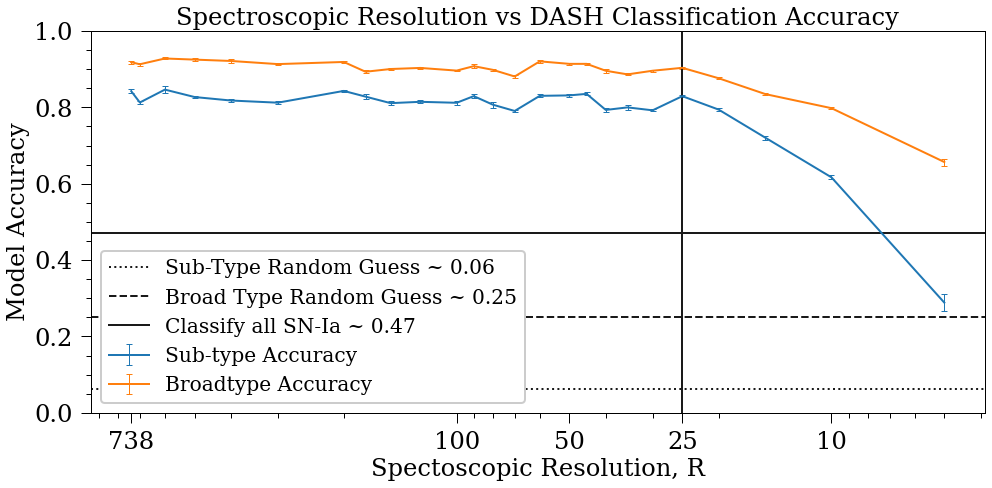

In [10]:
plt.figure(figsize=(14, 7))
plt.title("Spectroscopic Resolution vs DASH Classification Accuracy")

plt.errorbar(R_vals, acc_SN,
             yerr=acc_err_SN,
             elinewidth=1, capsize=3, c="tab:blue",
             marker="", ls="-", label="Sub-type Accuracy")
plt.errorbar(R_vals, bacc_SN,
             yerr=bacc_err_SN,
             elinewidth=1, capsize=3, c="tab:orange",
             marker="", ls="-", label="Broadtype Accuracy")

# plt.errorbar(R_vals, acc_SP,
#              yerr=acc_err_SP,
#              elinewidth=1, capsize=3, c="tab:blue",
#              marker="o", ls="-", label="Split by Spectra: Type Acc")

# plt.errorbar(R_vals, bacc_SP,
#              yerr=bacc_err_SP,
#              elinewidth=1, capsize=3, c="tab:orange",
#              marker="o", ls="-", label="Split by Spectra: Broadtype Acc")

plt.axhline(
    y=subtype_random_guess,
    ls=":", c="k",
    label=f"Sub-Type Random Guess ~ {1/16:.2f}")


plt.axhline(
    y=broadtype_random_guess,
    ls="--", c="k",
    label=f"Broad Type Random Guess ~ {1/4:.2f}")

plt.axhline(
    y=all_IA,
    ls="solid", c="k",
    label=f"Classify all SN-Ia ~ {all_IA:.2f}")

plt.axvline(
    x=25,
    ls="solid", c="k")

plt.legend(loc="lower left", framealpha=1)

plt.xlabel("Spectoscopic Resolution, R")
plt.ylabel("Model Accuracy")

plt.xscale("log")

plt.xticks(ticks=[738, 100, 50, 25, 10], labels=[738, 100, 50, 25, 10])

left, right = plt.xlim()
plt.xlim((right, left))
plt.ylim((0, 1))
plt.tight_layout()
plt.savefig(f"R_vs_acc.png")
plt.show()

Figure X: DASH macro F1-score is plotted as a function of spectroscopic resolution for each SN broad type: Ia, Ib, Ic, and II. The macro F1 score weights precision and recall from each class equally when calculating the metric. Using this metric instead of simple accuracy takes into account the severe class imbalance in this dataset. These results will therefore be more useful to someone investigating not just SN Type Ia (the most numerous class in the dataset) but other exotic SN subtypes like Ibc and interacting SN. We identify R = 25 as the spectral resolution after which model F1-score begins to degade. This indicates that spectroscopy can be accurately done at resolutions lower than that of the SED Machine.

SUBTPYES OF IBC, Ibc is not a subtype and collectively Ibc are not rare.